In [1]:
import torch
import torch.nn as nn
from torch.nn.functional import relu
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.amp import GradScaler
from collections import  Counter
import torch.nn.functional as F
import torch.optim as optim
import gc
from torch.optim import lr_scheduler
import cv2
import copy
import random
import os
from pathlib import Path
import glob
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.model_selection import train_test_split
import warnings 
warnings.filterwarnings("ignore")

In [2]:
root_path = Path("/kaggle/input/lyft-udacity-challenge")
dirs = ["dataA", "dataB", "dataC", "dataD", "dataE"]

images = []
masks = []

for d in dirs:
    img_path = root_path / d / d / "CameraRGB"
    msk_path = root_path / d / d / "CameraSeg"
    
    if img_path.exists():
        images.extend(sorted(img_path.glob("*.png")))
        masks.extend(sorted(msk_path.glob("*.png")))

print(f"Total images: {len(images)}")
print(f"Total masks: {len(masks)}")

Total images: 5000
Total masks: 5000


In [3]:
df = pd.DataFrame({"image": images, "mask": masks})

In [4]:
df.head()

,image,mask
0,/kaggle/input/lyft-udacity-challenge/dataA/dat...,/kaggle/input/lyft-udacity-challenge/dataA/dat...
1,/kaggle/input/lyft-udacity-challenge/dataA/dat...,/kaggle/input/lyft-udacity-challenge/dataA/dat...
2,/kaggle/input/lyft-udacity-challenge/dataA/dat...,/kaggle/input/lyft-udacity-challenge/dataA/dat...
3,/kaggle/input/lyft-udacity-challenge/dataA/dat...,/kaggle/input/lyft-udacity-challenge/dataA/dat...
4,/kaggle/input/lyft-udacity-challenge/dataA/dat...,/kaggle/input/lyft-udacity-challenge/dataA/dat...


In [5]:
print("Duplicate image paths:", df["image"].duplicated().sum())
print("Duplicate mask paths:", df["mask"].duplicated().sum())

Duplicate image paths: 0
Duplicate mask paths: 0


In [6]:
image_shapes = []
for img_path in df["image"].sample(200, random_state=42):
    img = cv2.imread(img_path)
    image_shapes.append(img.shape)

shape_counts = Counter(image_shapes)
shape_counts

Counter({(600, 800, 3): 200})

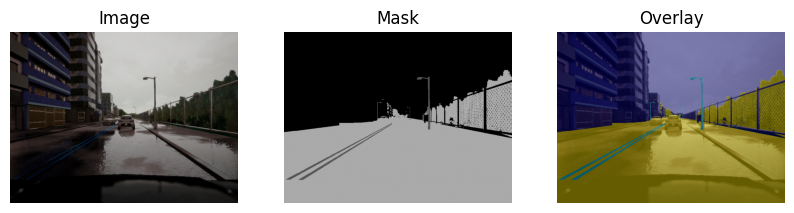

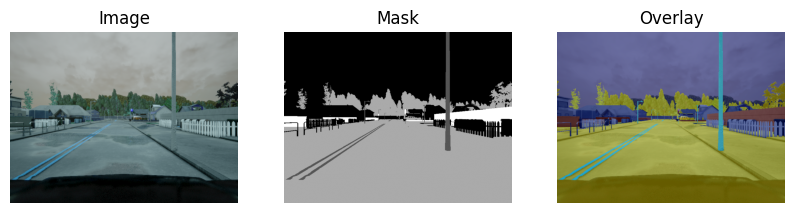

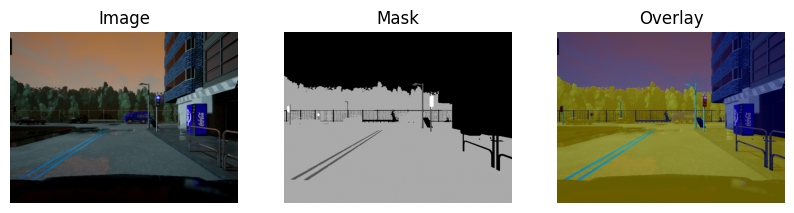

In [7]:
def visualize_sample(img_path, mask_path):
    img = cv2.imread(img_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    plt.figure(figsize=(10,4))

    plt.subplot(1,3,1)
    plt.title("Image")
    plt.imshow(img)
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.title("Mask")
    plt.imshow(mask, cmap="gray")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.title("Overlay")
    plt.imshow(img, cmap="gray")
    plt.imshow(mask, cmap="jet", alpha=0.4)
    plt.axis("off")

    plt.show()


for idx in random.sample(range(len(df)), 3):
    visualize_sample(df.iloc[idx]["image"], df.iloc[idx]["mask"])

In [8]:
mask_values = set()

for mask_path in df["mask"].sample(200, random_state=42):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask_values.update(np.unique(mask))

sorted(mask_values)

[np.uint8(0), np.uint8(1), np.uint8(2), np.uint8(3)]

In [9]:
# Load as RGB to see actual class encoding
mask_path = df["mask"].iloc[0]
mask_rgb = cv2.imread(mask_path, cv2.IMREAD_COLOR)
mask_rgb = cv2.cvtColor(mask_rgb, cv2.COLOR_BGR2RGB)

# Get unique colors
unique_colors = np.unique(mask_rgb.reshape(-1, 3), axis=0)
print(f"Number of unique colors: {len(unique_colors)}")
print("Unique RGB values:")
for color in unique_colors[:10]:
    print(f"  RGB: {color}")

Number of unique colors: 12
Unique RGB values:
  RGB: [0 0 0]
  RGB: [1 0 0]
  RGB: [2 0 0]
  RGB: [3 0 0]
  RGB: [5 0 0]
  RGB: [6 0 0]
  RGB: [7 0 0]
  RGB: [8 0 0]
  RGB: [9 0 0]
  RGB: [10  0  0]


In [10]:
class_ids = set()
for mask_path in df["mask"].sample(200, random_state=42):
    mask = cv2.imread(mask_path, cv2.IMREAD_COLOR)
    red_channel = mask[:, :, 2] 
    class_ids.update(np.unique(red_channel))

print(f"Total classes: {len(class_ids)}")
print(f"Class IDs: {sorted(class_ids)}")

Total classes: 13
Class IDs: [np.uint8(0), np.uint8(1), np.uint8(2), np.uint8(3), np.uint8(4), np.uint8(5), np.uint8(6), np.uint8(7), np.uint8(8), np.uint8(9), np.uint8(10), np.uint8(11), np.uint8(12)]


In [11]:
train_transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=15, p=0.3),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.GaussNoise(p=0.2),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  
    ToTensorV2()
])

val_test_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

In [12]:
class SegmentationDataset(Dataset):
    def __init__(self, df, transform=None):
        """
        Args:
            df (pd.DataFrame): DataFrame containing "image" and "mask" paths.
            transform (albumentations.Compose): Transformation pipeline.
        """
        self.df = df.reset_index(drop=True)
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        # 1. Fetch paths
        img_path = str(self.df.iloc[idx]["image"])
        mask_path = str(self.df.iloc[idx]["mask"])
        
        # 2. Read Image (BGR to RGB)
        image = cv2.imread(img_path)
        if image is None:
            raise ValueError(f"Could not load image: {img_path}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
   
        mask_bgr = cv2.imread(mask_path, cv2.IMREAD_COLOR)
        if mask_bgr is None:
            raise ValueError(f"Could not load mask: {mask_path}")
        
        mask = mask_bgr[:, :, 2]
        
        # 4. Apply Transforms
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]
            mask = augmented["mask"]
        
        if not isinstance(image, torch.Tensor):
            image = torch.from_numpy(image).permute(2, 0, 1).float()
            
        if not isinstance(mask, torch.Tensor):
            mask = torch.from_numpy(mask).long()
        else:
            mask = mask.long() 
            
        return image, mask

In [13]:
train_val_idx, test_idx = train_test_split(
    range(len(df)), 
    test_size=0.1, 
    random_state=42
)


train_idx, val_idx = train_test_split(
    train_val_idx, 
    test_size=0.2,  
    random_state=42
)


train_df = df.iloc[train_idx].reset_index(drop=True)
val_df = df.iloc[val_idx].reset_index(drop=True)
test_df = df.iloc[test_idx].reset_index(drop=True)

print(f"\nDataset split:")
print(f"Train: {len(train_df)} samples ({len(train_df)/len(df)*100:.1f}%)")
print(f"Validation: {len(val_df)} samples ({len(val_df)/len(df)*100:.1f}%)")
print(f"Test: {len(test_df)} samples ({len(test_df)/len(df)*100:.1f}%)")


train_dataset = SegmentationDataset(train_df, transform=train_transform)
val_dataset = SegmentationDataset(val_df, transform=val_test_transform)
test_dataset = SegmentationDataset(test_df, transform=val_test_transform)


Dataset split:
Train: 3600 samples (72.0%)
Validation: 900 samples (18.0%)
Test: 500 samples (10.0%)


In [14]:
class SpatialAttentionModule(nn.Module):
    def __init__(self, kernel_size):
        super(SpatialAttentionModule, self).__init__()
        assert kernel_size in (3, 7), "kernel size must be 3 or 7"
        padding = (kernel_size - 1) // 2
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)

    def forward(self, x):
        avg_pool = torch.mean(x, dim=1, keepdim=True)
        max_pool, _ = torch.max(x, dim=1, keepdim=True)
        cat_out = torch.cat([avg_pool, max_pool], dim=1)
        out = self.conv(cat_out)
        M = torch.sigmoid(out)
        return x * M

In [15]:
class SEBlock(nn.Module):
  def __init__(self, in_channels, reduction=16):
    super(SEBlock, self).__init__()
    reduced = max(1, in_channels // reduction)
    self.avg_global_pooling = nn.AdaptiveAvgPool2d((1, 1))
    self.fc = nn.Conv2d(in_channels, reduced, 1)
    self.relu = nn.ReLU(inplace=True)
    self.fc_out = nn.Conv2d(reduced, in_channels, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    avg_pooling = self.avg_global_pooling(x)
    fc1 = self.fc(avg_pooling)
    relu = self.relu(fc1)
    fc2 = self.fc_out(relu)
    sigmoid = self.sigmoid(fc2)
    return x * sigmoid

In [16]:
class CBAM(nn.Module):
    def __init__(self, in_channels, reduction=16, kernel_size=7):
        super(CBAM, self).__init__()
        self.channel_attention = SEBlock(in_channels, reduction)
        self.spatial_attention = SpatialAttentionModule(kernel_size)

    def forward(self, x):
      x = self.channel_attention.forward(x)
      x = self.spatial_attention.forward(x)
      return x

In [17]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_p=0.2):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.dropout = nn.Dropout2d(p=dropout_p)
    
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = relu(x)
        x = self.dropout(x)
        return x

class UNet(nn.Module):
    def __init__(self, n_classes, use_cbam=True, dropout_p=0.2):  
        super(UNet, self).__init__()
        self.use_cbam = use_cbam
        
        # ENCODER PART
        self.enc1_1 = ConvBlock(3, 64, dropout_p=dropout_p)
        self.enc1_2 = ConvBlock(64, 64, dropout_p=dropout_p)
        self.cbam_enc1 = CBAM(64, reduction=16) if use_cbam else None
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.enc2_1 = ConvBlock(64, 128, dropout_p=dropout_p)
        self.enc2_2 = ConvBlock(128, 128, dropout_p=dropout_p)
        self.cbam_enc2 = CBAM(128, reduction=16) if use_cbam else None
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.enc3_1 = ConvBlock(128, 256, dropout_p=dropout_p)
        self.enc3_2 = ConvBlock(256, 256, dropout_p=dropout_p)
        self.cbam_enc3 = CBAM(256, reduction=16) if use_cbam else None
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.enc4_1 = ConvBlock(256, 512, dropout_p=dropout_p)
        self.enc4_2 = ConvBlock(512, 512, dropout_p=dropout_p)
        self.cbam_enc4 = CBAM(512, reduction=16) if use_cbam else None
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # BOTTLENECK with higher dropout
        self.bottleneck1 = ConvBlock(512, 1024, dropout_p=dropout_p * 1.5)
        self.bottleneck2 = ConvBlock(1024, 1024, dropout_p=dropout_p * 1.5)
        self.cbam_bottleneck = CBAM(1024, reduction=16) if use_cbam else None
        
        # DECODER PART
        self.up1 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec1_1 = ConvBlock(1024, 512, dropout_p=dropout_p)
        self.dec1_2 = ConvBlock(512, 512, dropout_p=dropout_p)
        self.cbam_dec1 = CBAM(512, reduction=16) if use_cbam else None
        
        self.up2 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec2_1 = ConvBlock(512, 256, dropout_p=dropout_p)
        self.dec2_2 = ConvBlock(256, 256, dropout_p=dropout_p)
        self.cbam_dec2 = CBAM(256, reduction=16) if use_cbam else None
        
        self.up3 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec3_1 = ConvBlock(256, 128, dropout_p=dropout_p)
        self.dec3_2 = ConvBlock(128, 128, dropout_p=dropout_p)
        self.cbam_dec3 = CBAM(128, reduction=16) if use_cbam else None
        
        self.up4 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec4_1 = ConvBlock(128, 64, dropout_p=dropout_p)
        self.dec4_2 = ConvBlock(64, 64, dropout_p=dropout_p)
        self.cbam_dec4 = CBAM(64, reduction=16) if use_cbam else None

        self.out = nn.Conv2d(64, n_classes, 1)
        
    def forward(self, x):
        # ENCODER PART
        xe11 = self.enc1_1(x)
        xe12 = self.enc1_2(xe11)
        if self.use_cbam:
            xe12 = self.cbam_enc1(xe12)
        pool1 = self.pool1(xe12)
        
        xe21 = self.enc2_1(pool1)
        xe22 = self.enc2_2(xe21)
        if self.use_cbam:
            xe22 = self.cbam_enc2(xe22)
        pool2 = self.pool2(xe22)
        
        xe31 = self.enc3_1(pool2)
        xe32 = self.enc3_2(xe31)
        if self.use_cbam:
            xe32 = self.cbam_enc3(xe32)
        pool3 = self.pool3(xe32)
        
        xe41 = self.enc4_1(pool3)
        xe42 = self.enc4_2(xe41)
        if self.use_cbam:
            xe42 = self.cbam_enc4(xe42)
        pool4 = self.pool4(xe42)
        
        # BOTTLENECK
        xe51 = self.bottleneck1(pool4)
        xe52 = self.bottleneck2(xe51)
        if self.use_cbam:
            xe52 = self.cbam_bottleneck(xe52)
        
        # DECODER PART
        xu1 = self.up1(xe52)
        xu1 = torch.cat((xu1, xe42), dim=1)  # skip connection
        xu11 = self.dec1_1(xu1)
        xu12 = self.dec1_2(xu11)
        if self.use_cbam:
            xu12 = self.cbam_dec1(xu12)
        
        xu2 = self.up2(xu12)
        xu2 = torch.cat((xu2, xe32), dim=1)  # skip connection
        xu21 = self.dec2_1(xu2)
        xu22 = self.dec2_2(xu21)
        if self.use_cbam:
            xu22 = self.cbam_dec2(xu22)
        
        xu3 = self.up3(xu22)
        xu3 = torch.cat((xu3, xe22), dim=1)  # skip connection
        xu31 = self.dec3_1(xu3)
        xu32 = self.dec3_2(xu31)
        if self.use_cbam:
            xu32 = self.cbam_dec3(xu32)
        
        xu4 = self.up4(xu32)
        xu4 = torch.cat((xu4, xe12), dim=1)  # skip connection
        xu41 = self.dec4_1(xu4)
        xu42 = self.dec4_2(xu41)
        if self.use_cbam:
            xu42 = self.cbam_dec4(xu42)
        
        out = self.out(xu42)
        return out

In [18]:
def multiclass_dice_loss(pred, target, num_classes, smooth=1e-6):
    """Multi-class Dice loss"""
    pred = F.softmax(pred, dim=1)  
    
    dice_loss = 0
    for class_idx in range(num_classes):
        pred_class = pred[:, class_idx]
        target_class = (target == class_idx).float()
        
        pred_flat = pred_class.reshape(-1)
        target_flat = target_class.reshape(-1)
        
        intersection = (pred_flat * target_flat).sum()
        union = pred_flat.sum() + target_flat.sum()
        
        dice = (2. * intersection + smooth) / (union + smooth)
        dice_loss += (1 - dice)
    
    return dice_loss / num_classes

@torch.no_grad()
def multiclass_dice_score(pred, target, num_classes, smooth=1e-6):
    """Multi-class Dice score"""
    pred = torch.argmax(pred, dim=1)  
    
    dice_scores = []
    for class_idx in range(num_classes):
        pred_class = (pred == class_idx).float()
        target_class = (target == class_idx).float()
        
        intersection = (pred_class * target_class).sum()
        union = pred_class.sum() + target_class.sum()
        
        if union == 0:
            continue  
            
        dice = (2. * intersection + smooth) / (union + smooth)
        dice_scores.append(dice)
    
    return torch.tensor(dice_scores).mean()

@torch.no_grad()
def calculate_miou(pred, target, num_classes):
    """Mean Intersection over Union"""
    pred = torch.argmax(pred, dim=1)
    
    ious = []
    for class_idx in range(num_classes):
        pred_class = (pred == class_idx)
        target_class = (target == class_idx)
        
        intersection = (pred_class & target_class).sum().float()
        union = (pred_class | target_class).sum().float()
        
        if union == 0:
            continue
            
        iou = intersection / union
        ious.append(iou)
    
    return torch.tensor(ious).mean() if ious else torch.tensor(0.0)

In [19]:
class Trainer:
    def __init__(self, model, num_classes=13, patience=7, class_weights=None):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = model.to(self.device)
        self.num_classes = num_classes

        self.batch_size = 16
        self.accumulation_steps = 2
        
        # Early Stopping
        self.patience = patience
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False
        self.best_model_wts = copy.deepcopy(model.state_dict())

        self.scaler = GradScaler()

        # Multi-class loss with optional class weights
        if class_weights is not None:
            class_weights = torch.tensor(class_weights, dtype=torch.float32).to(self.device)
        self.ce_loss = nn.CrossEntropyLoss(weight=class_weights)
        
        # Optimizer
        self.optimizer = optim.Adam(self.model.parameters(), lr=1e-4, weight_decay=1e-5)

        # Scheduler
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode='min', factor=0.5, patience=3
        )

    def combined_loss(self, outputs, targets):
        """Combined CrossEntropy + Dice Loss for multi-class segmentation"""
        ce = self.ce_loss(outputs, targets)
        dice = multiclass_dice_loss(outputs, targets, num_classes=self.num_classes)
        return 0.5 * ce + 0.5 * dice

    def get_loader(self, dataset, shuffle=True):
        return DataLoader(
            dataset,
            batch_size=self.batch_size,
            shuffle=shuffle,
            num_workers=2,
            pin_memory=True,
            persistent_workers=True
        )

    def clean_memory(self):
        gc.collect()
        torch.cuda.empty_cache()

    def train_epoch(self, data_loader, epoch_idx):
        self.model.train()
        loss_total = 0.0

        self.optimizer.zero_grad(set_to_none=True)
        loop = tqdm(data_loader, desc=f"Epoch {epoch_idx+1} [Train]", leave=False)

        for batch_idx, (data, target) in enumerate(loop):
            data = data.to(self.device, non_blocking=True)
            target = target.to(self.device, non_blocking=True).long()

            with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
                output = self.model(data)
                loss = self.combined_loss(output, target)
                loss = loss / self.accumulation_steps

            self.scaler.scale(loss).backward()

            if (batch_idx + 1) % self.accumulation_steps == 0:
                self.scaler.step(self.optimizer)
                self.scaler.update()
                self.optimizer.zero_grad(set_to_none=True)

            loss_val = loss.item() * self.accumulation_steps
            loss_total += loss_val
            loop.set_postfix(loss=loss_val)

        if len(data_loader) % self.accumulation_steps != 0:
            self.scaler.step(self.optimizer)
            self.scaler.update()
            self.optimizer.zero_grad(set_to_none=True)
        
        self.clean_memory()

        avg_loss = loss_total / len(data_loader)
        print(f"Epoch {epoch_idx + 1} | Train Loss: {avg_loss:.4f}")
        return avg_loss

    @torch.no_grad()
    def validate_epoch(self, data_loader, epoch_idx):
        self.model.eval()

        val_loss = 0.0
        val_dice = 0.0
        val_miou = 0.0

        loop = tqdm(data_loader, desc=f"Epoch {epoch_idx+1} [Val]", leave=False)

        for data, target in loop:
            data = data.to(self.device, non_blocking=True)
            target = target.to(self.device, non_blocking=True).long()

            with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
                output = self.model(data)
                loss = self.combined_loss(output, target)

            val_loss += loss.item()
            val_dice += multiclass_dice_score(output, target, self.num_classes).item()
            val_miou += calculate_miou(output, target, self.num_classes).item()

        val_loss /= len(data_loader)
        val_dice /= len(data_loader)
        val_miou /= len(data_loader)

        self.clean_memory()

        current_lr = self.optimizer.param_groups[0]['lr']
        print(
            f"Epoch {epoch_idx + 1} | "
            f"Val Loss: {val_loss:.4f} | "
            f"Val Dice: {val_dice:.4f} | "
            f"Val mIoU: {val_miou:.4f} | "
            f"LR: {current_lr:.6f}"
        )

        self.scheduler.step(val_loss)

        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model_wts = copy.deepcopy(self.model.state_dict())
            torch.save(self.model.state_dict(), 'best_model.pth')
            print("  -> New best model saved!")
        else:
            self.counter += 1
            print(f"  -> EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True

        return val_loss, val_dice, val_miou

    def fit(self, train_loader, val_loader, epochs):
        for epoch in range(epochs):
            self.train_epoch(train_loader, epoch)
            self.validate_epoch(val_loader, epoch)
            
            if self.early_stop:
                print("Early stopping triggered.")
                self.model.load_state_dict(self.best_model_wts)
                break

        self.clean_memory()   

In [20]:
model = UNet(n_classes=13, use_cbam=True, dropout_p=0.2)


trainer = Trainer(model, num_classes=13, patience=7)


train_loader = trainer.get_loader(train_dataset, shuffle=True)
val_loader = trainer.get_loader(val_dataset, shuffle=False)

trainer.fit(train_loader, val_loader, epochs=150)

Epoch 1 | Train Loss: 1.6533


Epoch 1 | Val Loss: 1.4703 | Val Dice: 0.2588 | Val mIoU: 0.2228 | LR: 0.000100
  -> New best model saved!


Epoch 2 | Train Loss: 1.3363


Epoch 2 | Val Loss: 1.1176 | Val Dice: 0.3237 | Val mIoU: 0.2748 | LR: 0.000100
  -> New best model saved!


Epoch 3 | Train Loss: 1.0215


Epoch 3 | Val Loss: 0.8644 | Val Dice: 0.3738 | Val mIoU: 0.3252 | LR: 0.000100
  -> New best model saved!


Epoch 4 | Train Loss: 0.8334


Epoch 4 | Val Loss: 0.6962 | Val Dice: 0.4070 | Val mIoU: 0.3657 | LR: 0.000100
  -> New best model saved!


Epoch 5 | Train Loss: 0.7110


Epoch 5 | Val Loss: 0.5847 | Val Dice: 0.4154 | Val mIoU: 0.3779 | LR: 0.000100
  -> New best model saved!


Epoch 6 | Train Loss: 0.6344


Epoch 6 | Val Loss: 0.5219 | Val Dice: 0.4217 | Val mIoU: 0.3877 | LR: 0.000100
  -> New best model saved!


Epoch 7 | Train Loss: 0.5828


Epoch 7 | Val Loss: 0.4845 | Val Dice: 0.4294 | Val mIoU: 0.3952 | LR: 0.000100
  -> New best model saved!


Epoch 8 | Train Loss: 0.5459


Epoch 8 | Val Loss: 0.4573 | Val Dice: 0.4704 | Val mIoU: 0.4269 | LR: 0.000100
  -> New best model saved!


Epoch 9 | Train Loss: 0.5178


Epoch 9 | Val Loss: 0.4240 | Val Dice: 0.4940 | Val mIoU: 0.4521 | LR: 0.000100
  -> New best model saved!


Epoch 10 | Train Loss: 0.4934


Epoch 10 | Val Loss: 0.4096 | Val Dice: 0.5056 | Val mIoU: 0.4605 | LR: 0.000100
  -> New best model saved!


Epoch 11 | Train Loss: 0.4700


Epoch 11 | Val Loss: 0.3890 | Val Dice: 0.5296 | Val mIoU: 0.4789 | LR: 0.000100
  -> New best model saved!


Epoch 12 | Train Loss: 0.4530


Epoch 12 | Val Loss: 0.3757 | Val Dice: 0.5522 | Val mIoU: 0.4952 | LR: 0.000100
  -> New best model saved!


Epoch 13 | Train Loss: 0.4383


Epoch 13 | Val Loss: 0.3547 | Val Dice: 0.5799 | Val mIoU: 0.5199 | LR: 0.000100
  -> New best model saved!


Epoch 14 | Train Loss: 0.4225


Epoch 14 | Val Loss: 0.3419 | Val Dice: 0.5968 | Val mIoU: 0.5329 | LR: 0.000100
  -> New best model saved!


Epoch 15 | Train Loss: 0.4102


Epoch 15 | Val Loss: 0.3256 | Val Dice: 0.6149 | Val mIoU: 0.5491 | LR: 0.000100
  -> New best model saved!


Epoch 16 | Train Loss: 0.3977


Epoch 16 | Val Loss: 0.3170 | Val Dice: 0.6253 | Val mIoU: 0.5579 | LR: 0.000100
  -> New best model saved!


Epoch 17 | Train Loss: 0.3909


Epoch 17 | Val Loss: 0.3080 | Val Dice: 0.6346 | Val mIoU: 0.5678 | LR: 0.000100
  -> New best model saved!


Epoch 18 | Train Loss: 0.3798


Epoch 18 | Val Loss: 0.2993 | Val Dice: 0.6413 | Val mIoU: 0.5743 | LR: 0.000100
  -> New best model saved!


Epoch 19 | Train Loss: 0.3702


Epoch 19 | Val Loss: 0.2939 | Val Dice: 0.6457 | Val mIoU: 0.5793 | LR: 0.000100
  -> New best model saved!


Epoch 20 | Train Loss: 0.3671


Epoch 20 | Val Loss: 0.2897 | Val Dice: 0.6478 | Val mIoU: 0.5820 | LR: 0.000100
  -> New best model saved!


Epoch 21 | Train Loss: 0.3572


Epoch 21 | Val Loss: 0.2829 | Val Dice: 0.6536 | Val mIoU: 0.5888 | LR: 0.000100
  -> New best model saved!


Epoch 22 | Train Loss: 0.3510


Epoch 22 | Val Loss: 0.2814 | Val Dice: 0.6536 | Val mIoU: 0.5890 | LR: 0.000100
  -> New best model saved!


Epoch 23 | Train Loss: 0.3462


Epoch 23 | Val Loss: 0.2761 | Val Dice: 0.6589 | Val mIoU: 0.5946 | LR: 0.000100
  -> New best model saved!


Epoch 24 | Train Loss: 0.3428


Epoch 24 | Val Loss: 0.2711 | Val Dice: 0.6646 | Val mIoU: 0.6003 | LR: 0.000100
  -> New best model saved!


Epoch 25 | Train Loss: 0.3372


Epoch 25 | Val Loss: 0.2694 | Val Dice: 0.6726 | Val mIoU: 0.6046 | LR: 0.000100
  -> New best model saved!


Epoch 26 | Train Loss: 0.3358


Epoch 26 | Val Loss: 0.2620 | Val Dice: 0.6872 | Val mIoU: 0.6164 | LR: 0.000100
  -> New best model saved!


Epoch 27 | Train Loss: 0.3304


Epoch 27 | Val Loss: 0.2555 | Val Dice: 0.6943 | Val mIoU: 0.6227 | LR: 0.000100
  -> New best model saved!


Epoch 28 | Train Loss: 0.3253


Epoch 28 | Val Loss: 0.2561 | Val Dice: 0.6936 | Val mIoU: 0.6210 | LR: 0.000100
  -> EarlyStopping counter: 1 out of 7


Epoch 29 | Train Loss: 0.3200


Epoch 29 | Val Loss: 0.2548 | Val Dice: 0.6961 | Val mIoU: 0.6231 | LR: 0.000100
  -> New best model saved!


Epoch 30 | Train Loss: 0.3154


Epoch 30 | Val Loss: 0.2488 | Val Dice: 0.7006 | Val mIoU: 0.6279 | LR: 0.000100
  -> New best model saved!


Epoch 31 | Train Loss: 0.3124


Epoch 31 | Val Loss: 0.2410 | Val Dice: 0.7084 | Val mIoU: 0.6373 | LR: 0.000100
  -> New best model saved!


Epoch 32 | Train Loss: 0.3088


Epoch 32 | Val Loss: 0.2420 | Val Dice: 0.7082 | Val mIoU: 0.6359 | LR: 0.000100
  -> EarlyStopping counter: 1 out of 7


Epoch 33 | Train Loss: 0.3092


Epoch 33 | Val Loss: 0.2366 | Val Dice: 0.7137 | Val mIoU: 0.6424 | LR: 0.000100
  -> New best model saved!


Epoch 34 | Train Loss: 0.3036


Epoch 34 | Val Loss: 0.2352 | Val Dice: 0.7153 | Val mIoU: 0.6432 | LR: 0.000100
  -> New best model saved!


Epoch 35 | Train Loss: 0.2984


Epoch 35 | Val Loss: 0.2328 | Val Dice: 0.7183 | Val mIoU: 0.6473 | LR: 0.000100
  -> New best model saved!


Epoch 36 | Train Loss: 0.2982


Epoch 36 | Val Loss: 0.2289 | Val Dice: 0.7270 | Val mIoU: 0.6531 | LR: 0.000100
  -> New best model saved!


Epoch 37 | Train Loss: 0.2970


Epoch 37 | Val Loss: 0.2222 | Val Dice: 0.7464 | Val mIoU: 0.6659 | LR: 0.000100
  -> New best model saved!


Epoch 38 | Train Loss: 0.2897


Epoch 38 | Val Loss: 0.2156 | Val Dice: 0.7577 | Val mIoU: 0.6762 | LR: 0.000100
  -> New best model saved!


Epoch 39 | Train Loss: 0.2841


Epoch 39 | Val Loss: 0.2085 | Val Dice: 0.7642 | Val mIoU: 0.6821 | LR: 0.000100
  -> New best model saved!


Epoch 40 | Train Loss: 0.2800


Epoch 40 | Val Loss: 0.2062 | Val Dice: 0.7668 | Val mIoU: 0.6845 | LR: 0.000100
  -> New best model saved!


Epoch 41 | Train Loss: 0.2757


Epoch 41 | Val Loss: 0.2042 | Val Dice: 0.7691 | Val mIoU: 0.6870 | LR: 0.000100
  -> New best model saved!


Epoch 42 | Train Loss: 0.2688


Epoch 42 | Val Loss: 0.2039 | Val Dice: 0.7710 | Val mIoU: 0.6883 | LR: 0.000100
  -> New best model saved!


Epoch 43 | Train Loss: 0.2657


Epoch 43 | Val Loss: 0.1954 | Val Dice: 0.7802 | Val mIoU: 0.6994 | LR: 0.000100
  -> New best model saved!


Epoch 44 | Train Loss: 0.2668


Epoch 44 | Val Loss: 0.1963 | Val Dice: 0.7792 | Val mIoU: 0.6976 | LR: 0.000100
  -> EarlyStopping counter: 1 out of 7


Epoch 45 | Train Loss: 0.2627


Epoch 45 | Val Loss: 0.1938 | Val Dice: 0.7822 | Val mIoU: 0.7012 | LR: 0.000100
  -> New best model saved!


Epoch 46 | Train Loss: 0.2582


Epoch 46 | Val Loss: 0.1922 | Val Dice: 0.7836 | Val mIoU: 0.7028 | LR: 0.000100
  -> New best model saved!


Epoch 47 | Train Loss: 0.2571


Epoch 47 | Val Loss: 0.1889 | Val Dice: 0.7868 | Val mIoU: 0.7066 | LR: 0.000100
  -> New best model saved!


Epoch 48 | Train Loss: 0.2535


Epoch 48 | Val Loss: 0.1865 | Val Dice: 0.7895 | Val mIoU: 0.7100 | LR: 0.000100
  -> New best model saved!


Epoch 49 | Train Loss: 0.2530


Epoch 49 | Val Loss: 0.1863 | Val Dice: 0.7895 | Val mIoU: 0.7097 | LR: 0.000100
  -> New best model saved!


Epoch 50 | Train Loss: 0.2503


Epoch 50 | Val Loss: 0.1822 | Val Dice: 0.7941 | Val mIoU: 0.7153 | LR: 0.000100
  -> New best model saved!


Epoch 51 | Train Loss: 0.2477


Epoch 51 | Val Loss: 0.1827 | Val Dice: 0.7945 | Val mIoU: 0.7154 | LR: 0.000100
  -> EarlyStopping counter: 1 out of 7


Epoch 52 | Train Loss: 0.2435


Epoch 52 | Val Loss: 0.1826 | Val Dice: 0.7947 | Val mIoU: 0.7157 | LR: 0.000100
  -> EarlyStopping counter: 2 out of 7


Epoch 53 | Train Loss: 0.2451


Epoch 53 | Val Loss: 0.1808 | Val Dice: 0.7964 | Val mIoU: 0.7179 | LR: 0.000100
  -> New best model saved!


Epoch 54 | Train Loss: 0.2438


Epoch 54 | Val Loss: 0.1802 | Val Dice: 0.7968 | Val mIoU: 0.7186 | LR: 0.000100
  -> New best model saved!


Epoch 55 | Train Loss: 0.2420


Epoch 55 | Val Loss: 0.1795 | Val Dice: 0.7978 | Val mIoU: 0.7195 | LR: 0.000100
  -> New best model saved!


Epoch 56 | Train Loss: 0.2408


Epoch 56 | Val Loss: 0.1767 | Val Dice: 0.8004 | Val mIoU: 0.7226 | LR: 0.000100
  -> New best model saved!


Epoch 57 | Train Loss: 0.2409


Epoch 57 | Val Loss: 0.1771 | Val Dice: 0.8001 | Val mIoU: 0.7222 | LR: 0.000100
  -> EarlyStopping counter: 1 out of 7


Epoch 58 | Train Loss: 0.2359


Epoch 58 | Val Loss: 0.1749 | Val Dice: 0.8023 | Val mIoU: 0.7255 | LR: 0.000100
  -> New best model saved!


Epoch 59 | Train Loss: 0.2330


Epoch 59 | Val Loss: 0.1742 | Val Dice: 0.8032 | Val mIoU: 0.7264 | LR: 0.000100
  -> New best model saved!


Epoch 60 | Train Loss: 0.2341


Epoch 60 | Val Loss: 0.1724 | Val Dice: 0.8052 | Val mIoU: 0.7287 | LR: 0.000100
  -> New best model saved!


Epoch 61 | Train Loss: 0.2320


Epoch 61 | Val Loss: 0.1731 | Val Dice: 0.8044 | Val mIoU: 0.7277 | LR: 0.000100
  -> EarlyStopping counter: 1 out of 7


Epoch 62 | Train Loss: 0.2323


Epoch 62 | Val Loss: 0.1719 | Val Dice: 0.8050 | Val mIoU: 0.7286 | LR: 0.000100
  -> New best model saved!


Epoch 63 | Train Loss: 0.2324


Epoch 63 | Val Loss: 0.1714 | Val Dice: 0.8056 | Val mIoU: 0.7294 | LR: 0.000100
  -> New best model saved!


Epoch 64 | Train Loss: 0.2316


Epoch 64 | Val Loss: 0.1714 | Val Dice: 0.8063 | Val mIoU: 0.7302 | LR: 0.000100
  -> New best model saved!


Epoch 65 | Train Loss: 0.2287


Epoch 65 | Val Loss: 0.1699 | Val Dice: 0.8069 | Val mIoU: 0.7310 | LR: 0.000100
  -> New best model saved!


Epoch 66 | Train Loss: 0.2251


Epoch 66 | Val Loss: 0.1681 | Val Dice: 0.8096 | Val mIoU: 0.7343 | LR: 0.000100
  -> New best model saved!


Epoch 67 | Train Loss: 0.2244


Epoch 67 | Val Loss: 0.1675 | Val Dice: 0.8096 | Val mIoU: 0.7346 | LR: 0.000100
  -> New best model saved!


Epoch 68 | Train Loss: 0.2262


Epoch 68 | Val Loss: 0.1662 | Val Dice: 0.8112 | Val mIoU: 0.7365 | LR: 0.000100
  -> New best model saved!


Epoch 69 | Train Loss: 0.2236


Epoch 69 | Val Loss: 0.1662 | Val Dice: 0.8115 | Val mIoU: 0.7369 | LR: 0.000100
  -> New best model saved!


Epoch 70 | Train Loss: 0.2230


Epoch 70 | Val Loss: 0.1663 | Val Dice: 0.8100 | Val mIoU: 0.7350 | LR: 0.000100
  -> EarlyStopping counter: 1 out of 7


Epoch 71 | Train Loss: 0.2214


Epoch 71 | Val Loss: 0.1654 | Val Dice: 0.8120 | Val mIoU: 0.7375 | LR: 0.000100
  -> New best model saved!


Epoch 72 | Train Loss: 0.2206


Epoch 72 | Val Loss: 0.1630 | Val Dice: 0.8144 | Val mIoU: 0.7406 | LR: 0.000100
  -> New best model saved!


Epoch 73 | Train Loss: 0.2215


Epoch 73 | Val Loss: 0.1633 | Val Dice: 0.8131 | Val mIoU: 0.7390 | LR: 0.000100
  -> EarlyStopping counter: 1 out of 7


Epoch 74 | Train Loss: 0.2214


Epoch 74 | Val Loss: 0.1631 | Val Dice: 0.8141 | Val mIoU: 0.7406 | LR: 0.000100
  -> EarlyStopping counter: 2 out of 7


Epoch 75 | Train Loss: 0.2179


Epoch 75 | Val Loss: 0.1622 | Val Dice: 0.8153 | Val mIoU: 0.7415 | LR: 0.000100
  -> New best model saved!


Epoch 76 | Train Loss: 0.2187


Epoch 76 | Val Loss: 0.1614 | Val Dice: 0.8156 | Val mIoU: 0.7424 | LR: 0.000100
  -> New best model saved!


Epoch 77 | Train Loss: 0.2193


Epoch 77 | Val Loss: 0.1616 | Val Dice: 0.8154 | Val mIoU: 0.7420 | LR: 0.000100
  -> EarlyStopping counter: 1 out of 7


Epoch 78 | Train Loss: 0.2174


Epoch 78 | Val Loss: 0.1614 | Val Dice: 0.8157 | Val mIoU: 0.7424 | LR: 0.000100
  -> New best model saved!


Epoch 79 | Train Loss: 0.2175


Epoch 79 | Val Loss: 0.1596 | Val Dice: 0.8173 | Val mIoU: 0.7444 | LR: 0.000100
  -> New best model saved!


Epoch 80 | Train Loss: 0.2146


Epoch 80 | Val Loss: 0.1598 | Val Dice: 0.8176 | Val mIoU: 0.7451 | LR: 0.000100
  -> EarlyStopping counter: 1 out of 7


Epoch 81 | Train Loss: 0.2127


Epoch 81 | Val Loss: 0.1589 | Val Dice: 0.8191 | Val mIoU: 0.7468 | LR: 0.000100
  -> New best model saved!


Epoch 82 | Train Loss: 0.2132


Epoch 82 | Val Loss: 0.1586 | Val Dice: 0.8188 | Val mIoU: 0.7465 | LR: 0.000100
  -> New best model saved!


Epoch 83 | Train Loss: 0.2125


Epoch 83 | Val Loss: 0.1589 | Val Dice: 0.8184 | Val mIoU: 0.7461 | LR: 0.000100
  -> EarlyStopping counter: 1 out of 7


Epoch 84 | Train Loss: 0.2108


Epoch 84 | Val Loss: 0.1585 | Val Dice: 0.8180 | Val mIoU: 0.7456 | LR: 0.000100
  -> New best model saved!


Epoch 85 | Train Loss: 0.2118


Epoch 85 | Val Loss: 0.1575 | Val Dice: 0.8194 | Val mIoU: 0.7472 | LR: 0.000100
  -> New best model saved!


Epoch 86 | Train Loss: 0.2101


Epoch 86 | Val Loss: 0.1553 | Val Dice: 0.8216 | Val mIoU: 0.7502 | LR: 0.000100
  -> New best model saved!


Epoch 87 | Train Loss: 0.2089


Epoch 87 | Val Loss: 0.1573 | Val Dice: 0.8195 | Val mIoU: 0.7474 | LR: 0.000100
  -> EarlyStopping counter: 1 out of 7


Epoch 88 | Train Loss: 0.2083


Epoch 88 | Val Loss: 0.1550 | Val Dice: 0.8222 | Val mIoU: 0.7512 | LR: 0.000100
  -> New best model saved!


Epoch 89 | Train Loss: 0.2083


Epoch 89 | Val Loss: 0.1561 | Val Dice: 0.8208 | Val mIoU: 0.7492 | LR: 0.000100
  -> EarlyStopping counter: 1 out of 7


Epoch 90 | Train Loss: 0.2076


Epoch 90 | Val Loss: 0.1533 | Val Dice: 0.8235 | Val mIoU: 0.7528 | LR: 0.000100
  -> New best model saved!


Epoch 91 | Train Loss: 0.2077


Epoch 91 | Val Loss: 0.1535 | Val Dice: 0.8229 | Val mIoU: 0.7521 | LR: 0.000100
  -> EarlyStopping counter: 1 out of 7


Epoch 92 | Train Loss: 0.2066


Epoch 92 | Val Loss: 0.1533 | Val Dice: 0.8234 | Val mIoU: 0.7527 | LR: 0.000100
  -> New best model saved!


Epoch 93 | Train Loss: 0.2055


Epoch 93 | Val Loss: 0.1520 | Val Dice: 0.8249 | Val mIoU: 0.7549 | LR: 0.000100
  -> New best model saved!


Epoch 94 | Train Loss: 0.2073


Epoch 94 | Val Loss: 0.1552 | Val Dice: 0.8216 | Val mIoU: 0.7505 | LR: 0.000100
  -> EarlyStopping counter: 1 out of 7


Epoch 95 | Train Loss: 0.2042


Epoch 95 | Val Loss: 0.1531 | Val Dice: 0.8235 | Val mIoU: 0.7528 | LR: 0.000100
  -> EarlyStopping counter: 2 out of 7


Epoch 96 | Train Loss: 0.2044


Epoch 96 | Val Loss: 0.1525 | Val Dice: 0.8245 | Val mIoU: 0.7541 | LR: 0.000100
  -> EarlyStopping counter: 3 out of 7


Epoch 97 | Train Loss: 0.2042


Epoch 97 | Val Loss: 0.1501 | Val Dice: 0.8268 | Val mIoU: 0.7574 | LR: 0.000100
  -> New best model saved!


Epoch 98 | Train Loss: 0.2029


Epoch 98 | Val Loss: 0.1514 | Val Dice: 0.8252 | Val mIoU: 0.7554 | LR: 0.000100
  -> EarlyStopping counter: 1 out of 7


Epoch 99 | Train Loss: 0.2017


Epoch 99 | Val Loss: 0.1507 | Val Dice: 0.8265 | Val mIoU: 0.7570 | LR: 0.000100
  -> EarlyStopping counter: 2 out of 7


Epoch 100 | Train Loss: 0.2026


Epoch 100 | Val Loss: 0.1499 | Val Dice: 0.8270 | Val mIoU: 0.7578 | LR: 0.000100
  -> New best model saved!


Epoch 101 | Train Loss: 0.2019


Epoch 101 | Val Loss: 0.1500 | Val Dice: 0.8265 | Val mIoU: 0.7570 | LR: 0.000100
  -> EarlyStopping counter: 1 out of 7


Epoch 102 | Train Loss: 0.2015


Epoch 102 | Val Loss: 0.1499 | Val Dice: 0.8265 | Val mIoU: 0.7571 | LR: 0.000100
  -> New best model saved!


Epoch 103 | Train Loss: 0.2007


Epoch 103 | Val Loss: 0.1494 | Val Dice: 0.8275 | Val mIoU: 0.7585 | LR: 0.000100
  -> New best model saved!


Epoch 104 | Train Loss: 0.2002


Epoch 104 | Val Loss: 0.1486 | Val Dice: 0.8283 | Val mIoU: 0.7597 | LR: 0.000100
  -> New best model saved!


Epoch 105 | Train Loss: 0.2015


Epoch 105 | Val Loss: 0.1481 | Val Dice: 0.8289 | Val mIoU: 0.7603 | LR: 0.000100
  -> New best model saved!


Epoch 106 | Train Loss: 0.1998


Epoch 106 | Val Loss: 0.1485 | Val Dice: 0.8276 | Val mIoU: 0.7585 | LR: 0.000100
  -> EarlyStopping counter: 1 out of 7


Epoch 107 | Train Loss: 0.2003


Epoch 107 | Val Loss: 0.1476 | Val Dice: 0.8288 | Val mIoU: 0.7602 | LR: 0.000100
  -> New best model saved!


Epoch 108 | Train Loss: 0.2002


Epoch 108 | Val Loss: 0.1476 | Val Dice: 0.8292 | Val mIoU: 0.7610 | LR: 0.000100
  -> New best model saved!


Epoch 109 | Train Loss: 0.1992


Epoch 109 | Val Loss: 0.1467 | Val Dice: 0.8301 | Val mIoU: 0.7621 | LR: 0.000100
  -> New best model saved!


Epoch 110 | Train Loss: 0.1952


Epoch 110 | Val Loss: 0.1463 | Val Dice: 0.8305 | Val mIoU: 0.7626 | LR: 0.000100
  -> New best model saved!


Epoch 111 | Train Loss: 0.1938


Epoch 111 | Val Loss: 0.1463 | Val Dice: 0.8305 | Val mIoU: 0.7627 | LR: 0.000100
  -> New best model saved!


Epoch 112 | Train Loss: 0.1955


Epoch 112 | Val Loss: 0.1470 | Val Dice: 0.8291 | Val mIoU: 0.7610 | LR: 0.000100
  -> EarlyStopping counter: 1 out of 7


Epoch 113 | Train Loss: 0.1961


Epoch 113 | Val Loss: 0.1472 | Val Dice: 0.8299 | Val mIoU: 0.7618 | LR: 0.000100
  -> EarlyStopping counter: 2 out of 7


Epoch 114 | Train Loss: 0.1960


Epoch 114 | Val Loss: 0.1455 | Val Dice: 0.8305 | Val mIoU: 0.7628 | LR: 0.000100
  -> New best model saved!


Epoch 115 | Train Loss: 0.1940


Epoch 115 | Val Loss: 0.1453 | Val Dice: 0.8308 | Val mIoU: 0.7632 | LR: 0.000100
  -> New best model saved!


Epoch 116 | Train Loss: 0.1951


Epoch 116 | Val Loss: 0.1462 | Val Dice: 0.8301 | Val mIoU: 0.7622 | LR: 0.000100
  -> EarlyStopping counter: 1 out of 7


Epoch 117 | Train Loss: 0.1939


Epoch 117 | Val Loss: 0.1454 | Val Dice: 0.8310 | Val mIoU: 0.7634 | LR: 0.000100
  -> EarlyStopping counter: 2 out of 7


Epoch 118 | Train Loss: 0.1923


Epoch 118 | Val Loss: 0.1455 | Val Dice: 0.8307 | Val mIoU: 0.7627 | LR: 0.000100
  -> EarlyStopping counter: 3 out of 7


Epoch 119 | Train Loss: 0.1917


Epoch 119 | Val Loss: 0.1453 | Val Dice: 0.8308 | Val mIoU: 0.7631 | LR: 0.000100
  -> New best model saved!


Epoch 120 | Train Loss: 0.1918


Epoch 120 | Val Loss: 0.1453 | Val Dice: 0.8308 | Val mIoU: 0.7632 | LR: 0.000100
  -> EarlyStopping counter: 1 out of 7


Epoch 121 | Train Loss: 0.1910


Epoch 121 | Val Loss: 0.1471 | Val Dice: 0.8289 | Val mIoU: 0.7608 | LR: 0.000100
  -> EarlyStopping counter: 2 out of 7


Epoch 122 | Train Loss: 0.1929


Epoch 122 | Val Loss: 0.1453 | Val Dice: 0.8311 | Val mIoU: 0.7638 | LR: 0.000100
  -> EarlyStopping counter: 3 out of 7


Epoch 123 | Train Loss: 0.1925


Epoch 123 | Val Loss: 0.1449 | Val Dice: 0.8323 | Val mIoU: 0.7651 | LR: 0.000100
  -> New best model saved!


Epoch 124 | Train Loss: 0.1922


Epoch 124 | Val Loss: 0.1439 | Val Dice: 0.8321 | Val mIoU: 0.7650 | LR: 0.000100
  -> New best model saved!


Epoch 125 | Train Loss: 0.1924


Epoch 125 | Val Loss: 0.1433 | Val Dice: 0.8327 | Val mIoU: 0.7657 | LR: 0.000100
  -> New best model saved!


Epoch 126 | Train Loss: 0.1899


Epoch 126 | Val Loss: 0.1424 | Val Dice: 0.8337 | Val mIoU: 0.7671 | LR: 0.000100
  -> New best model saved!


Epoch 127 | Train Loss: 0.1909


Epoch 127 | Val Loss: 0.1427 | Val Dice: 0.8337 | Val mIoU: 0.7671 | LR: 0.000100
  -> EarlyStopping counter: 1 out of 7


Epoch 128 | Train Loss: 0.1909


Epoch 128 | Val Loss: 0.1427 | Val Dice: 0.8333 | Val mIoU: 0.7666 | LR: 0.000100
  -> EarlyStopping counter: 2 out of 7


Epoch 129 | Train Loss: 0.1897


Epoch 129 | Val Loss: 0.1422 | Val Dice: 0.8341 | Val mIoU: 0.7676 | LR: 0.000100
  -> New best model saved!


Epoch 130 | Train Loss: 0.1870


Epoch 130 | Val Loss: 0.1414 | Val Dice: 0.8343 | Val mIoU: 0.7681 | LR: 0.000100
  -> New best model saved!


Epoch 131 | Train Loss: 0.1889


Epoch 131 | Val Loss: 0.1417 | Val Dice: 0.8346 | Val mIoU: 0.7683 | LR: 0.000100
  -> EarlyStopping counter: 1 out of 7


Epoch 132 | Train Loss: 0.1899


Epoch 132 | Val Loss: 0.1429 | Val Dice: 0.8335 | Val mIoU: 0.7668 | LR: 0.000100
  -> EarlyStopping counter: 2 out of 7


Epoch 133 | Train Loss: 0.1895


Epoch 133 | Val Loss: 0.1422 | Val Dice: 0.8346 | Val mIoU: 0.7683 | LR: 0.000100
  -> EarlyStopping counter: 3 out of 7


Epoch 134 | Train Loss: 0.1868


Epoch 134 | Val Loss: 0.1403 | Val Dice: 0.8356 | Val mIoU: 0.7699 | LR: 0.000100
  -> New best model saved!


Epoch 135 | Train Loss: 0.1882


Epoch 135 | Val Loss: 0.1411 | Val Dice: 0.8345 | Val mIoU: 0.7683 | LR: 0.000100
  -> EarlyStopping counter: 1 out of 7


Epoch 136 | Train Loss: 0.1885


Epoch 136 | Val Loss: 0.1403 | Val Dice: 0.8357 | Val mIoU: 0.7700 | LR: 0.000100
  -> EarlyStopping counter: 2 out of 7


Epoch 137 | Train Loss: 0.1874


Epoch 137 | Val Loss: 0.1400 | Val Dice: 0.8361 | Val mIoU: 0.7704 | LR: 0.000100
  -> New best model saved!


Epoch 138 | Train Loss: 0.1869


Epoch 138 | Val Loss: 0.1408 | Val Dice: 0.8349 | Val mIoU: 0.7689 | LR: 0.000100
  -> EarlyStopping counter: 1 out of 7


Epoch 139 | Train Loss: 0.1860


Epoch 139 | Val Loss: 0.1396 | Val Dice: 0.8366 | Val mIoU: 0.7711 | LR: 0.000100
  -> New best model saved!


Epoch 140 | Train Loss: 0.1860


Epoch 140 | Val Loss: 0.1391 | Val Dice: 0.8369 | Val mIoU: 0.7716 | LR: 0.000100
  -> New best model saved!


Epoch 141 | Train Loss: 0.1847


Epoch 141 | Val Loss: 0.1394 | Val Dice: 0.8365 | Val mIoU: 0.7710 | LR: 0.000100
  -> EarlyStopping counter: 1 out of 7


Epoch 142 | Train Loss: 0.1841


Epoch 142 | Val Loss: 0.1395 | Val Dice: 0.8371 | Val mIoU: 0.7718 | LR: 0.000100
  -> EarlyStopping counter: 2 out of 7


Epoch 143 | Train Loss: 0.1846


Epoch 143 | Val Loss: 0.1388 | Val Dice: 0.8373 | Val mIoU: 0.7722 | LR: 0.000100
  -> New best model saved!


Epoch 144 | Train Loss: 0.1840


Epoch 144 | Val Loss: 0.1397 | Val Dice: 0.8364 | Val mIoU: 0.7711 | LR: 0.000100
  -> EarlyStopping counter: 1 out of 7


Epoch 145 | Train Loss: 0.1856


Epoch 145 | Val Loss: 0.1374 | Val Dice: 0.8385 | Val mIoU: 0.7738 | LR: 0.000100
  -> New best model saved!


Epoch 146 | Train Loss: 0.1845


Epoch 146 | Val Loss: 0.1394 | Val Dice: 0.8364 | Val mIoU: 0.7709 | LR: 0.000100
  -> EarlyStopping counter: 1 out of 7


Epoch 147 | Train Loss: 0.1857


Epoch 147 | Val Loss: 0.1393 | Val Dice: 0.8364 | Val mIoU: 0.7709 | LR: 0.000100
  -> EarlyStopping counter: 2 out of 7


Epoch 148 | Train Loss: 0.1849


Epoch 148 | Val Loss: 0.1383 | Val Dice: 0.8377 | Val mIoU: 0.7728 | LR: 0.000100
  -> EarlyStopping counter: 3 out of 7


Epoch 149 | Train Loss: 0.1841


Epoch 149 | Val Loss: 0.1379 | Val Dice: 0.8380 | Val mIoU: 0.7732 | LR: 0.000100
  -> EarlyStopping counter: 4 out of 7


Epoch 150 | Train Loss: 0.1798


Epoch 150 | Val Loss: 0.1368 | Val Dice: 0.8386 | Val mIoU: 0.7741 | LR: 0.000050
  -> New best model saved!


In [21]:
def test_model(model, test_loader, num_classes, model_path='best_model.pth'):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    # 1. Load the best weights
    print(f"Loading weights from {model_path}...")
    checkpoint = torch.load(model_path, map_location=device)
    
    # If you used the dictionary sav|e method from the previous step:
    if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
    else:
        model.load_state_dict(checkpoint)
        
    model.eval()
    
    test_dice = 0.0
    test_miou = 0.0
    
    print("Starting Evaluation...")
    with torch.no_grad():
        # Use autocast if you trained with mixed precision
        with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
            for data, target in tqdm(test_loader, desc="Testing"):
                data = data.to(device, non_blocking=True)
                target = target.to(device, non_blocking=True).long()
                
                output = model(data)
                
                # Calculate metrics using your existing functions
                test_dice += multiclass_dice_score(output, target, num_classes).item()
                test_miou += calculate_miou(output, target, num_classes).item()
                
    # 2. Calculate Averages
    avg_dice = test_dice / len(test_loader)
    avg_miou = test_miou / len(test_loader)
    
    print("\n" + "="*30)
    print("FINAL TEST RESULTS")
    print(f"Mean Dice Score: {avg_dice:.4f}")
    print(f"Mean IoU (mIoU): {avg_miou:.4f}")
    print("="*30)
    
    return avg_dice, avg_miou

In [22]:
def visualize_prediction(model, dataset, idx=0):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    
    # Get data
    image, mask = dataset[idx] # image: [C, H, W], mask: [H, W]
    
    # Prepare input for model: add batch dimension [1, C, H, W]
    input_tensor = image.unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(input_tensor)
        # Convert output to class predictions
        pred = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()
        
    # Plotting
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    # Un-normalize image if you used Normalize transform
    # (assuming standard ImageNet mean/std)
    img_show = image.permute(1, 2, 0).numpy()
    img_show = (img_show * 0.229) + 0.485 
    plt.imshow(np.clip(img_show, 0, 1))
    plt.title("Original Image")
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(mask.numpy(), cmap='jet')
    plt.title("Ground Truth")
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(pred, cmap='jet')
    plt.title("Model Prediction")
    plt.axis('off')
    
    plt.show()

In [23]:
test_loader = DataLoader(
            test_dataset,
            batch_size = 4,
            shuffle = False,
        )

In [24]:
avg_dice, avg_miou = test_model(model, test_loader, num_classes=13)


avg_dice, avg_miou

Loading weights from best_model.pth...
Starting Evaluation...


Testing: 100%|██████████| 125/125 [00:23<00:00,  5.21it/s]


FINAL TEST RESULTS
Mean Dice Score: 0.8523
Mean IoU (mIoU): 0.7850


(0.8523338303565979, 0.7850157480239868)

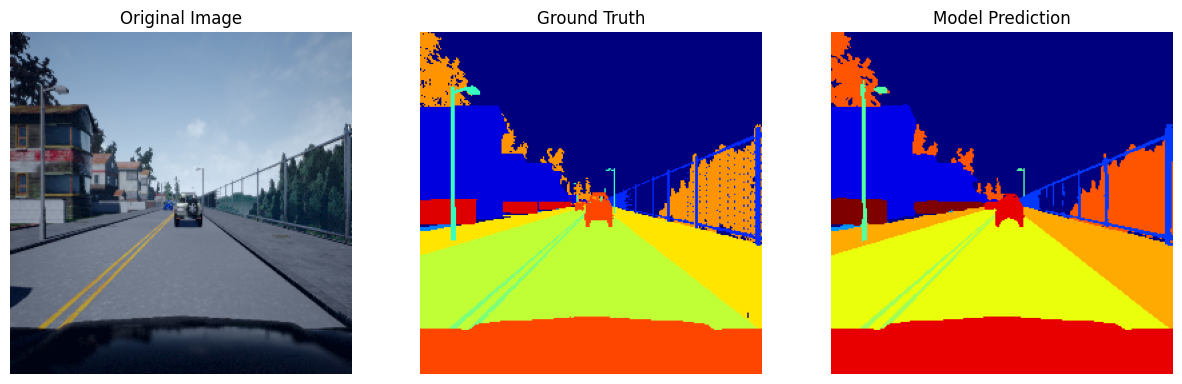

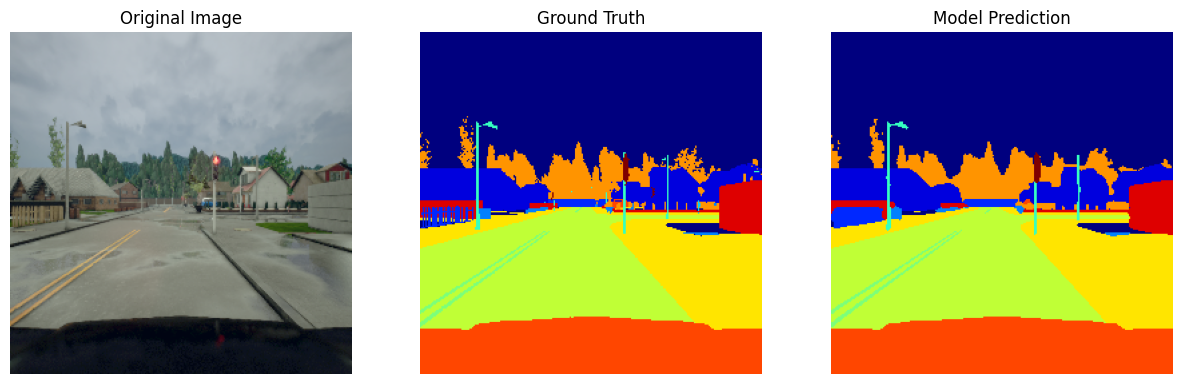

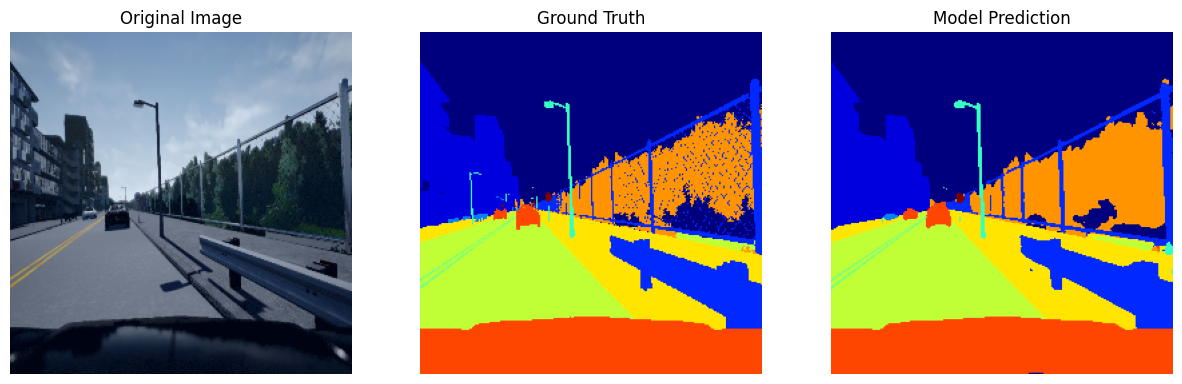

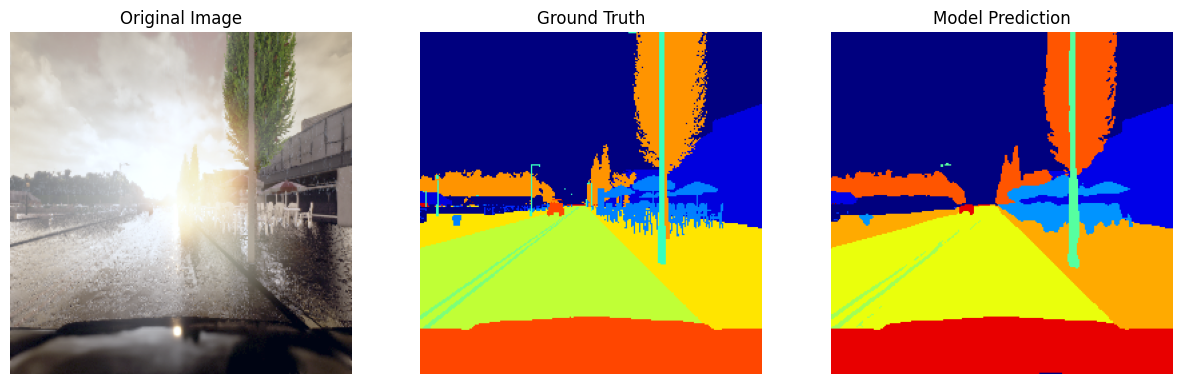

In [25]:
visualize_prediction(model, test_dataset, idx=10)
visualize_prediction(model, test_dataset, idx=50)
visualize_prediction(model, test_dataset, idx=40)
visualize_prediction(model, test_dataset, idx=20)